In [1]:
%load_ext autoreload
%autoreload 2

# This notebook uses only full input windows for training, validation and testing on the 2018 editions of OhioT1DM dataset (no interpolation is applied when creating the input-target pairs)

## Imports, top level definitions and data loading

In [6]:
import keras_lmu
import pandas as pd
import os
import tensorflow as tf

from core.pre_processing import build_ohio_dataset, build_windows, get_patient_window
from core.utils import compile_and_fit, plot_loss

In [14]:
SAMPL_FREQ = 5

PATIENTS_2018 = ["559", "563", "570", "575", "588", "591"]
PATIENTS_2020 = ["540", "544", "552", "567", "584", "596"]

model_name = "lmu_2018_ph30min_full_wins"

In [13]:
# Load dataset
dataset_2018 = build_ohio_dataset("2018")

Using time to peak: 100 for patient 559
Identified 35 gaps for train set of 559
Identified 7 gaps for val set of 559
Identified 11 gaps for test set of 559
Using time to peak: 100 for patient 563
Identified 15 gaps for train set of 563
Identified 6 gaps for val set of 563
Identified 3 gaps for test set of 563
Using time to peak: 100 for patient 570
Identified 15 gaps for train set of 570
Identified 5 gaps for val set of 570
Identified 9 gaps for test set of 570
Using time to peak: 100 for patient 575
Identified 56 gaps for train set of 575
Identified 16 gaps for val set of 575
Identified 10 gaps for test set of 575
Using time to peak: 100 for patient 588
Identified 9 gaps for train set of 588
Identified 1 gaps for val set of 588
Identified 2 gaps for test set of 588
Using time to peak: 100 for patient 591
Identified 23 gaps for train set of 591
Identified 3 gaps for val set of 591
Identified 4 gaps for test set of 591


## Setup params for the model and input

In [15]:
# Path where to store the trained models
root_path = "models"

# 6 steps -> 30 minutes prediction horizon
PH = 6
batch_size = 256

# 30 minutes of input
input_len = 30

features = ["Time", "Glucose", "Rapid Insulin sub_tissue", "Carbohydrates gut", "finger_stick"]

## Create pre-processed input-target pairs for the model
Additionally create input-target pairs per each patient so that we can evaluate the performance individually per patient

In [16]:
w_2018, _ = build_windows(dataset_2018, features, input_len // SAMPL_FREQ, 1, PH, drop_noisy=False, batch_size=batch_size, min_max_scale=False, interpolate=False)

In [17]:
patient_windows_2018 = {}
for p_tr_df, p_v_df, p_tst_df, patient_id in dataset_2018:
    patient_windows_2018[patient_id] = get_patient_window(
        (p_tr_df, p_v_df, p_tst_df),
        features,
        input_len // SAMPL_FREQ,
        1,
        PH,
        drop_noisy=False,
        batch_size=batch_size,
        min_max_scale=False,
        interpolate=False,
    )

## Train and evaluate models

In [18]:
def train_model(patient_windows, model_name: str, train_window):
    lmu_layer = keras_lmu.LMU(
        memory_d=4,
        order=52,
        theta=input_len // SAMPL_FREQ,
        hidden_to_memory=True,
        memory_to_memory=False,
        input_to_hidden=False,
        hidden_cell=tf.keras.layers.LSTMCell(units=72),
        return_sequences=False,
        dropout=0.1,
        recurrent_dropout=0,
    )
    inputs = tf.keras.Input((input_len // SAMPL_FREQ, 4))
    lmus = lmu_layer(inputs)
    outputs = tf.keras.layers.Dense(1)(lmus)
    output_plus_input = tf.keras.layers.Add()([outputs, inputs[:, -1, 0]])

    model = tf.keras.Model(inputs=inputs, outputs=output_plus_input)
    print(model.summary())

    history = compile_and_fit(model, train_window, max_epochs=300, learning_rate=10**-3, patience=35, store_model=model_name)
    plot_loss(history, "Loss", False)

    best_model = tf.keras.models.load_model(os.path.join(root_path, model_name))

    results_val = []
    results_test = []

    for patient_id, patient_w in patient_windows.items():
        print("Evaluating on patient_id:", patient_id)
        val_p = best_model.evaluate(patient_w.val, verbose=0)[1]
        test_p = best_model.evaluate(patient_w.test, verbose=0)[1]
        results_val.append((model_name, patient_id, val_p))
        results_test.append((model_name, patient_id, test_p))
    return results_val, results_test

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6, 4)]               0         []                            
                                                                                                  
 lmu (LMU)                   (None, 72)                   81232     ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 1)                    73        ['lmu[0][0]']                 
                                                                                                  
 tf.__operators__.getitem (  (None,)                      0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                             

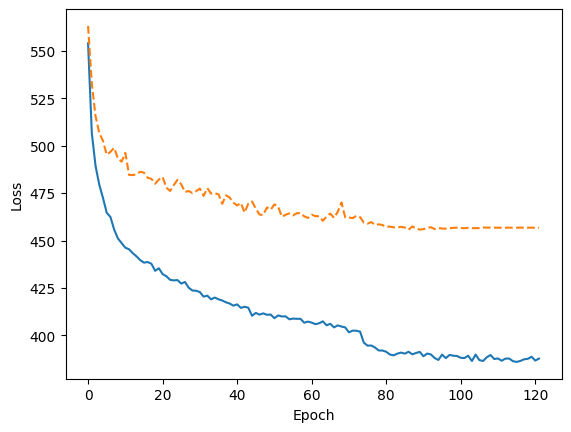

In [19]:
val_errs, test_errs = train_model(patient_windows_2018, f"{model_name}_0", w_2018)

In [27]:
test_errs

[('lmu_2018_ph30min_full_wins_0', '559', 17.653114318847656),
 ('lmu_2018_ph30min_full_wins_0', '563', 17.471981048583984),
 ('lmu_2018_ph30min_full_wins_0', '570', 15.05150318145752),
 ('lmu_2018_ph30min_full_wins_0', '575', 20.91191291809082),
 ('lmu_2018_ph30min_full_wins_0', '588', 16.66705322265625),
 ('lmu_2018_ph30min_full_wins_0', '591', 20.447036743164062)]

In [28]:
val_errs

[('lmu_2018_ph30min_full_wins_0', '559', 20.28468132019043),
 ('lmu_2018_ph30min_full_wins_0', '563', 17.87293815612793),
 ('lmu_2018_ph30min_full_wins_0', '570', 16.675077438354492),
 ('lmu_2018_ph30min_full_wins_0', '575', 20.914928436279297),
 ('lmu_2018_ph30min_full_wins_0', '588', 18.90682029724121),
 ('lmu_2018_ph30min_full_wins_0', '591', 30.00229263305664)]

In [20]:
df_results_test = pd.DataFrame(test_errs, columns=['Model iteration', 'Patient ID', 'RMSE'])
df_results_test['Model'] = df_results_test['Model iteration'].str.replace(r'_\d+$', '', regex=True)
df_results_test.groupby(['Model iteration'])['RMSE'].agg(['mean'])

,mean
Model iteration,
lmu_2018_ph30min_full_wins_0,18.033767
